# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
#from cycler import cycler
import numpy as np
import scipy as sc
from scipy import stats
#from scipy.stats import beta

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [4]:
COLOR = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown',
         'darkred','red']
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN']#,'YK']

In [5]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [6]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'parametre/param_Fit_%s_fct_velocity_2_step_False_whitening.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

# Variation de h

In [7]:
from lmfit import  Model, Parameters

In [8]:
def fct_BCP(x, h) :

    p_bar, r, beliefs = bcp.inference(x, h=h, p0=.5)
    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode='expectation')
    
    return p_hat

In [9]:
def fit(h, proba, bet, va):
    params = Parameters()
    model = Model(fct_BCP)

    params.add('h', value=h, min=0.00001, max=0.99999)
    
    result_res = model.fit(bet, params, x=proba, nan_policy='omit')
    result_v_ant = model.fit(va, params, x=proba, nan_policy='omit')

    h_bet = result_res.values['h']
    h_va = result_v_ant.values['h']
    
    return h_bet, h_va

In [10]:
h_bet_pause, h_va_pause = [], []
h_bet_block, h_va_block = [], []
h_bet_sujet, h_va_sujet = [], []

for x in range(len(exp)) :
    
    prob_sujet, bet_sujet, v_anti_sujet = [], [], []

    p = exp[x]['p']
    tau = exp[x]['N_trials']/5.
    h = 1./tau 
    #hs = h*np.logspace(-1., 1., 50)
    #print(hs)
    bet = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    v_anti = param[x]['v_anti']

    
    h_bet_block.append([])
    h_bet_pause.append([])
    h_va_block.append([])
    h_va_pause.append([])

    for block in range(exp[x]['N_blocks']):

        prob_block = p[:, block, 0]
        h_bet, h_va = fit(h, prob_block, bet[:, block], v_anti[block])

        h_bet_block[x].append(h_bet)
        h_va_block[x].append(h_va)

        prob_sujet.extend(p[:, block, 0])
        bet_sujet.extend(bet[:, block])
        v_anti_sujet.extend(v_anti[block])
        #----------------------------------------------------
        # Pour chaque pause !
        #----------------------------------------------------
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            prob_pause = p[liste[a]:liste[a+1], block, 0]
            h_bet, h_va = fit(h, prob_pause, bet[liste[a]:liste[a+1], block], v_anti[block][liste[a]:liste[a+1]])

            h_bet_pause[x].append(h_bet)
            h_va_pause[x].append(h_va)
                

    h_bet, h_va = fit(h, prob_sujet, bet_sujet, v_anti_sujet)
    h_bet_sujet.append(h_bet)
    h_va_sujet.append(h_va)

In [11]:
def regress(ax, p, data, c, minx=0, miny=0, maxx=1, maxy=1, t_label=14) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=c, linewidth=2)
    ax.text(maxx-((maxx-minx)/16.180), miny+((maxy-miny)/4), 'r = %0.3f'%(r_), fontsize=t_label/1.2, ha='right', color=c)
    ax.text(maxx-((maxx-minx)/16.180), miny+((maxy-miny)/10), 'p_value = %0.3f'%(p_value), fontsize=t_label/1.2, ha='right', color=c)

    return ax

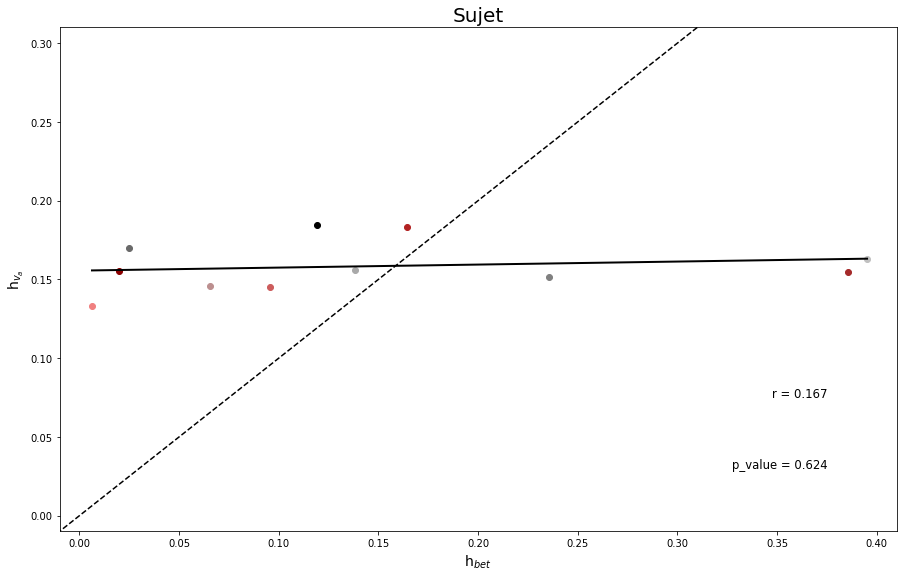

In [12]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)))

for x, color in enumerate(COLOR[:len(list_sujet)]):
    axs.scatter(h_bet_sujet[x], h_va_sujet[x],color=color)

#------------------------------------------------------------------------
axs.set_title('Sujet', fontsize=20)
axs.set_xlabel('h$_{bet}$', fontsize=14)
axs.set_ylabel('h$_{v_a}$', fontsize=14)
axs.axis([-0.01 ,0.41,-0.01,0.31])


regress(axs, h_bet_sujet, h_va_sujet, 'k', minx=0, miny=0, maxx=0.4, maxy=0.3)
axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

In [13]:
def scatter_mean(bet, va, titre) :
    fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)))

    m_bet, m_va = [], []
    for x in range(len(bet)):
        axs.errorbar(np.mean(bet[x]), np.mean(va[x]),
                    xerr=np.std(bet[x]), yerr=np.std(va[x]),
                    color='r', fmt='o', elinewidth=0.8)
        
        m_bet.append(np.mean(bet[x]))
        m_va.append(np.mean(va[x]))

    axs.set_title(titre, fontsize=20)
    axs.set_xlabel('h$_{bet}$', fontsize=20)
    axs.set_ylabel('h$_{v_a}$', fontsize=20)
    axs.axis([-0.02 ,0.62,-0.01,0.31])
    axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')

    regress(axs, m_bet, m_va, 'k', minx=0, miny=0, maxx=0.6, maxy=0.3, t_label=20)

    plt.show()
    return fig, axs

In [14]:
exts = ['.png', '.svg']

Moyenne par Sujet block


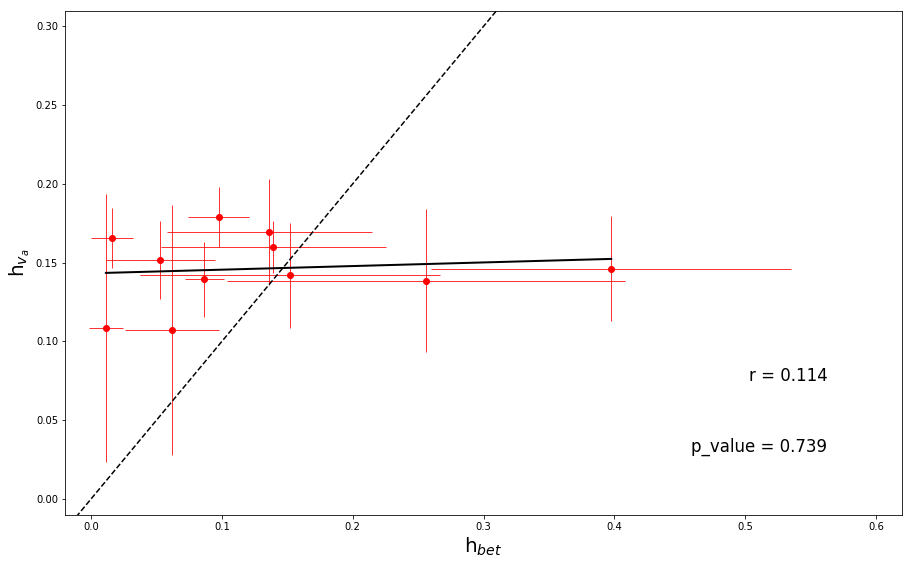

In [15]:
print('Moyenne par Sujet block')
fig, axs = scatter_mean(h_bet_block, h_va_block, '')
for ext in exts: fig.savefig('ms/figures/5_inter-individual_differences' + ext, dpi=400)

Moyenne par Sujet pause


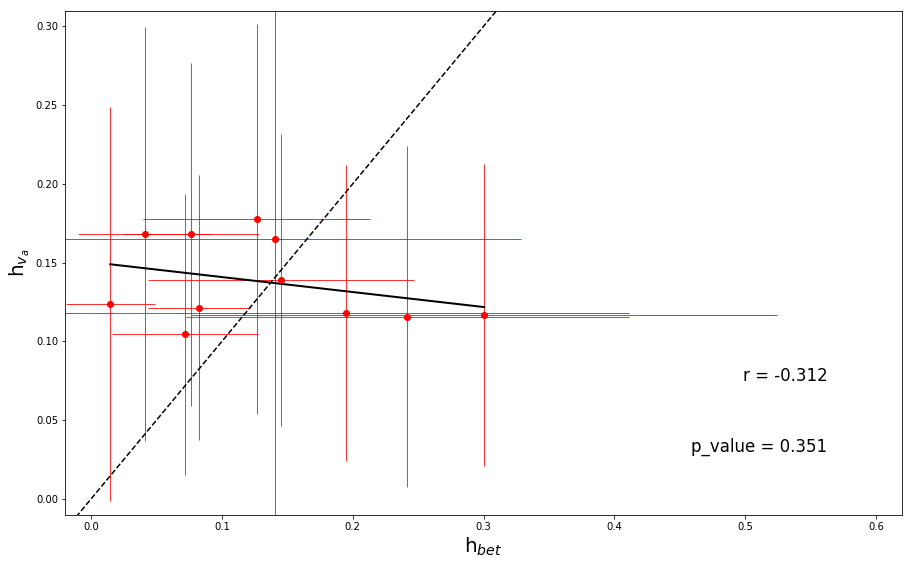

In [16]:
print('Moyenne par Sujet pause')
fig, axs = scatter_mean(h_bet_pause, h_va_pause, '')